# Client/server for IoT - an example code
## 측정한 signal의 값은 noise를 포함한다.
Sensor로 읽은 값은 noise가 포함되어 있기 때문에 변화가 있고, 실제 값을 추정하기가 곤란하다. 

아래 그림은 실제 값은 sine curve지만(`signal`), gausian noise가 더해져서 변화 무쌍하다(`measured`). 실제 우리가 측정하는 sensor data는 이런 값이 추출된다.

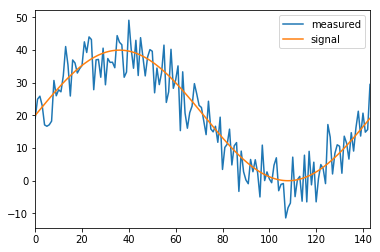

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Fs = 24 * 6
f = 1
sample = Fs

t = np.arange(sample)
k = 0.5
avg = 20
a = 20
signal = a * np.sin(2 * np.pi * f * t / Fs) + avg
noise = np.random.normal(scale=a/4, size=len(signal))
measured = signal + noise
df = pd.DataFrame({'signal': signal, 'measured': measured} )
df.plot()
plt.show()

측정된 값으로 실제 값을 알아낼 수는 없다. 하지만, 과거 측정값의 추이를 감안하여 새로 측정한 값을 원래 값에 가깝도록 보정할 수는 있다.Moving average가 그것이며, 최근 값은 가중치를 높게, 먼 과거일수록 가중치를 낮추는 EWMA(Exponential Weighted Moving Average)가 널리 사용되고 있다. 

아래 `smooth` curve는 EWMA로 보정한 moving average를 plotting한 것이다. Measured signal 보다 smoothing되었고, 실체 sine curve에 보다 가까움을 알 수 있다. (Mean square error가 작다.) 즉, 비교적 noise가 제거되었음을 확인할 수 있다.

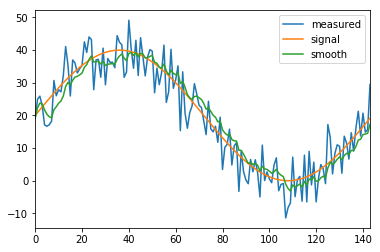

In [2]:
df['smooth'] = df['measured'].ewm(span=10).mean()
df.plot()
plt.show()

## Sensor data의 측정과 EWMA smoothing

In [3]:
import random, math

random.seed(113)
def gen_data(mean, deviation, samples=100):
    """Simulate reading sensor's data, adding noise to sine curve.
    
    :param mean: mean of sine curve
    :param deviation: deviation of sine curve
    :param samples: total number of samples to be generated
    :return: sensor data (float)
    """

    # Get values from the sensors
    Fs = samples
    f = 1
    for t in range(samples):
        signal = deviation * math.sin(2 * math.pi * f * t / Fs) + mean
        noise = random.gauss(mu=deviation/4, sigma=deviation/4)
        measured = signal + noise
        yield measured
        
gen_temp = gen_data(mean=20, deviation=20, samples=10)
gen_humid = gen_data(mean=50, deviation=15, samples=10)
for t in gen_temp:
    print(t)
print()
# You may use while loop
while True:
    try:
        h = next(gen_humid)
    except StopIteration:
        break
    print(h)

34.87027242184287
38.67427650219527
43.85537143215785
43.08608890988933
33.243434402696536
23.8603468410409
20.462445318542073
-0.6507255792784008
3.824963066362121
19.64669145825141

50.70248991705674
62.663946931305915
64.58523025136148
69.5496287429662
53.51610309894643
55.627529094123474
44.80679911031533
38.44388744498316
33.58309382470726
52.80488984867783


In [4]:
def ewma(generator, alpha=0.25):
    s = None
    for y in generator:
        s = alpha*y + (1-alpha)*s if s else y
        yield s

gen_temp = gen_data(mean=20, deviation=20, samples=10)
gen_humid = gen_data(mean=50, deviation=15, samples=10)
smooth_temp_data = [t for t in ewma(gen_temp)]
smooth_humid_data = [h for h in ewma(gen_humid)]
print(smooth_temp_data)
print(smooth_humid_data)

[25.46579229236861, 26.58534104673186, 29.79526659094721, 31.84092411531791, 33.724217131289365, 32.639846866253095, 27.649581453063625, 23.035669951041022, 18.64619513696013, 16.983475374107282]
[56.2980001926126, 59.19564515293639, 62.02704075161927, 63.03221617609893, 63.983104679308155, 60.009539373297855, 57.42521530064466, 54.650676972506204, 51.38232032464177, 50.69080318486686]


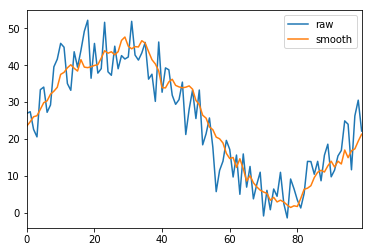

In [5]:
raw_temp = [t for t in gen_data(mean=20, deviation=20, samples=100)]
smooth_temp = [t for t in ewma(gen_data(mean=20, deviation=20, samples=100))]
df = pd.DataFrame({'raw': raw_temp, 'smooth': smooth_temp} )
df.plot()
plt.show()

## IOT request/response message - an example
```
<request message> ::= <request object in JSON format with UTF-8 encoding> <LF>

<request object> ::=
    {   'method': 'POST',
        'deviceid': <device id>,
        'msgid': <messge id>,
        'data': {'temperature': 28.5, 'humidity': 71},
    }

<response message> ::= <response object in JSON format with UTF-8 encoding> <LF>

<response object> ::=
    {   'status': 'OK' | 'ERROR <error msg>',
        'deviceid': <device id>
        'msgid': <messge id>
      [ 'activate': {'aircon': 'ON', 'led': 'OFF' } ]  # optional
    }

<LF> ::= b'\n'
```

## iot/iotclient.py:
Sensor data는 주기적으로 읽는 것으로 가정한다. 즉, 지정된 interval 마다 sensor에서 값을 읽고 request message에 data field에 삽입해 송신한다. Response message 도착했다는 event와 함께 timeout event를 처리하기
적절한 방법이 I/O multiplexing 기법이다.
`select(timeout=interval)`은 timeout 이내에 `EVENT_READ`가 발생하거나, 아니면 timeout이 발생한다.
따라서, event가 발생한 후에 interval 만큼 대기하기 때문에 지정한 주기마다 timeout이 발생하지 않고 delay될 수 있다. 

`select_perioic(interval)` method는 정확히 interval 마다, timeout을 발생시키도록 설계된 것으로, 
event가 발생했을 때 남은 시간을 계산하여 timeout을 변경한다.

Request message에 `msgid`가 정의되어 있고, server는 어떤 request에 대한 response인지 `msgid`를 삽입하여
회신하기 때문에, request 송신과 response 수신을 asynchronous하게 처리할 수 있다. Pipeling이 가능하다.

Usage: 
```bash
python iotclient.py host:port deviceid
```

## iot/iotserver.py:
`socketserver` 모듈의 `ThreadingTCPServer`를 이용하여, request handler의 `handle` method만 implementation한 예다.

매 request message마다 다음 순서로 처리한다.
1. get a request message in JSON and converts into dict
2. Extract the sensor data from the request
3. Insert sensor data into DB table and retrieve information to control the actuators
4. Apply rules to control actuators
5. Reply resonse message